In [3]:
import pandas as pd

# 文件路径
crime_data_path = "data/crime_data.csv"
housing_data_path = "data/median_price_paid.csv"
population_data_path = "data/population_density.csv"
gva_data_path = "data/gva_data.csv"
travel_time_data_path = "data/travel_time.csv"

# 设置筛选年份范围
selected_years = list(range(2011, 2020))

# 加载犯罪数据
crime_data = pd.read_csv(crime_data_path)

# 仅保留 "Major Category" 为 "Arson and Criminal Damage" 的记录
crime_data = crime_data[crime_data["Major Category"] == "VIOLENCE AGAINST THE PERSON"]

# 加载人口密度数据，提取必要列
population_data = pd.read_csv(population_data_path)
if "LSOA 2021 Code" in population_data.columns and "Area Sq Km" in population_data.columns:
    # 提取 LSOA 和 Area Sq Km
    area_data = population_data[["LSOA 2021 Code", "Area Sq Km"]].drop_duplicates()
    area_data.rename(columns={"LSOA 2021 Code": "LSOA Code"}, inplace=True)
else:
    raise KeyError("人口密度数据中缺少 'LSOA 2021 Code' 或 'Area Sq Km' 列，请检查文件并更新代码。")

# 合并犯罪数据和面积数据
crime_data = crime_data.merge(area_data, on="LSOA Code", how="left")
crime_numeric_columns = crime_data.columns[5:]  # 假设数值列从第6列开始
crime_data[crime_numeric_columns] = crime_data[crime_numeric_columns].apply(pd.to_numeric, errors="coerce")

crime_data = pd.concat([
    crime_data,
    pd.DataFrame({
        "Total Crime": crime_data[crime_numeric_columns].sum(axis=1, skipna=True),
        "Crime Density": crime_data[crime_numeric_columns].sum(axis=1, skipna=True) / crime_data["Area Sq Km"]
    })
], axis=1)
crime_data = crime_data[["LSOA Code", "LSOA Name", "Borough", "Crime Density"]]



# 加载房价数据
housing_data = pd.read_csv(housing_data_path)

# 确定需要转换的列：年份列包含 "Year ending"
year_columns = [col for col in housing_data.columns if "Year ending" in col]

# 将数据转换为长格式并筛选年份范围
housing_data = housing_data.melt(
    id_vars=["LSOA code", "LSOA name"],
    value_vars=year_columns,
    var_name="Year",
    value_name="Median House Price"
)
housing_data["Year"] = housing_data["Year"].str.extract(r"(\d{4})").dropna().astype(int)
housing_data = housing_data[housing_data["Year"].isin(selected_years)]

# 移除房价中的逗号，并将其转换为数值类型
housing_data["Median House Price"] = housing_data["Median House Price"].str.replace(",", "", regex=False)
housing_data["Median House Price"] = pd.to_numeric(housing_data["Median House Price"], errors="coerce")
housing_data.dropna(subset=["Median House Price"], inplace=True)

# 按年份排序并计算房价变化率
housing_data.sort_values(by=["LSOA code", "Year"], inplace=True)
housing_data["Price Change"] = housing_data.groupby("LSOA code")["Median House Price"].pct_change()

# 转换人口密度数据为长格式并筛选年份范围
population_density_data = population_data.melt(
    id_vars=["LSOA 2021 Code", "LSOA 2021 Name"],
    value_vars=[col for col in population_data.columns if "People per Sq Km" in col],
    var_name="Year",
    value_name="Population Density"
)
population_density_data["Year"] = population_density_data["Year"].str.extract(r"(\d{4})").astype(int)
population_density_data = population_density_data[population_density_data["Year"].isin(selected_years)]
population_density_data.rename(columns={"LSOA 2021 Code": "LSOA Code"}, inplace=True)

# 加载 GVA 数据并筛选年份范围
gva_data = pd.read_csv(gva_data_path)
gva_data = gva_data.melt(
    id_vars=["LSOA code"],
    var_name="Year",
    value_name="GVA"
)
gva_data = gva_data[gva_data["Year"].str.contains(r"^\d{4}$", na=False)]
gva_data["Year"] = gva_data["Year"].astype(int)
gva_data = gva_data[gva_data["Year"].isin(selected_years)]
gva_data.dropna(subset=["GVA"], inplace=True)

# 加载到警察局的平均时间数据
travel_time_data = pd.read_csv(travel_time_data_path)
travel_time_data[["pre12", "pre24", "post12", "post24"]] = travel_time_data[["pre12", "pre24", "post12", "post24"]].apply(pd.to_numeric, errors="coerce")
travel_time_data["Average Travel Time"] = travel_time_data[["pre12", "pre24", "post12", "post24"]].mean(axis=1)
travel_time_data = travel_time_data[["lsoa", "Average Travel Time"]]
travel_time_data.rename(columns={"lsoa": "LSOA Code"}, inplace=True)

# 合并所有数据
merged_data = crime_data.merge(housing_data, left_on="LSOA Code", right_on="LSOA code", how="left")
merged_data = merged_data.merge(population_density_data, on=["LSOA Code", "Year"], how="left")
merged_data = merged_data.merge(gva_data, left_on=["LSOA Code", "Year"], right_on=["LSOA code", "Year"], how="left")
merged_data = merged_data.merge(travel_time_data, on="LSOA Code", how="left")

# 删除多余列
merged_data = merged_data.drop(columns=["LSOA code_x", "LSOA code_y", "LSOA name"])

# 输出整合后的数据
print("整合后的数据样例：")
print(merged_data.head())

# 清理人口密度中的千位分隔符
population_density_data["Population Density"] = population_density_data["Population Density"].str.replace(",", "").astype(float)

# 整合后的数据中再处理千位分隔符（确保清理过所有列）
merged_data["Population Density"] = merged_data["Population Density"].replace(",", "", regex=True).astype(float)

# 输出清理后的整合数据
print("整合后的数据样例（清理后的）：")
print(merged_data.head())

整合后的数据样例：
   LSOA Code                  LSOA Name    Borough  Crime Density    Year  \
0  E01000006  Barking and Dagenham 016A  E09000002          821.0  2011.0   
1  E01000006  Barking and Dagenham 016A  E09000002          821.0  2011.0   
2  E01000006  Barking and Dagenham 016A  E09000002          821.0  2011.0   
3  E01000006  Barking and Dagenham 016A  E09000002          821.0  2011.0   
4  E01000006  Barking and Dagenham 016A  E09000002          821.0  2012.0   

   Median House Price  Price Change             LSOA 2021 Name  \
0            232500.0           NaN  Barking and Dagenham 016A   
1            225000.0     -0.032258  Barking and Dagenham 016A   
2            240000.0      0.066667  Barking and Dagenham 016A   
3            240500.0      0.002083  Barking and Dagenham 016A   
4            245500.0      0.020790  Barking and Dagenham 016A   

  Population Density    GVA  Average Travel Time  
0             11,808  4.804             9.380255  
1             11,808  4.804 

In [4]:
import statsmodels.api as sm

merged_data["Crime Density Change"] = merged_data.groupby("LSOA Code")["Crime Density"].pct_change().fillna(0)
merged_data["Lagged Crime Density Change"] = merged_data.groupby("LSOA Code")["Crime Density Change"].shift(1)
merged_data["Lagged Price Change"] = merged_data.groupby("LSOA Code")["Price Change"].shift(1)
regression_data = merged_data.dropna(subset=["Crime Density Change", "Price Change", "Lagged Crime Density Change", "Lagged Price Change"])

# 数据清理：筛选非缺失值
filtered_data = merged_data.dropna(subset=["Crime Density", "Median House Price", "Population Density", "Average Travel Time"])

# 模型 1: 犯罪率对房价的影响
X1 = filtered_data[["Crime Density", "Population Density", "Average Travel Time"]]
X1 = sm.add_constant(X1)  # 添加截距项
y1 = filtered_data["Median House Price"]

model1 = sm.OLS(y1, X1).fit()
print("模型 1: 犯罪率对房价的影响")
print(model1.summary())

# 模型 2: 房价对犯罪率的影响
X2 = filtered_data[["Median House Price", "Population Density", "Average Travel Time"]]
X2 = sm.add_constant(X2)  # 添加截距项
y2 = filtered_data["Crime Density"]

model2 = sm.OLS(y2, X2).fit()
print("\n模型 2: 房价对犯罪率的影响")
print(model2.summary())


模型 1: 犯罪率对房价的影响
                            OLS Regression Results                            
Dep. Variable:     Median House Price   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     1644.
Date:                Mon, 13 Jan 2025   Prob (F-statistic):               0.00
Time:                        22:49:30   Log-Likelihood:            -5.0035e+06
No. Observations:              356070   AIC:                         1.001e+07
Df Residuals:                  356066   BIC:                         1.001e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const             

In [5]:
# 创建收入中位数的 DataFrame
income_data = pd.DataFrame({
    "Year": [
        1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991,
        1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006,
        2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021
    ],
    "Median Income": [
        13682, 15137, 15722, 16227, 15969, 15722, 15886, 16387, 17107, 17801, 18705, 19877, 20391, 
        20903, 21523, 20895, 20329, 20866, 20926, 22086, 22649, 23126, 24605, 25019, 26613, 27474, 
        27989, 28769, 29095, 29073, 29511, 29166, 29205, 29165, 28481, 27828, 28544, 29782, 30303, 
        31121, 30377, 30625, 31883, 32529, 32349
    ]
})

# 合并收入中位数数据到整合数据集
merged_data = pd.merge(merged_data, income_data, on="Year", how="left")

merged_data


,LSOA Code,LSOA Name,Borough,Crime Density,Year,Median House Price,Price Change,LSOA 2021 Name,Population Density,GVA,Average Travel Time,Crime Density Change,Lagged Crime Density Change,Lagged Price Change,Median Income
0,E01000006,Barking and Dagenham 016A,E09000002,821.000000,2011.0,232500.0,NaN,Barking and Dagenham 016A,11808.0,4.804,9.380255,0.000000,NaN,NaN,28481.0
1,E01000006,Barking and Dagenham 016A,E09000002,821.000000,2011.0,225000.0,-0.032258,Barking and Dagenham 016A,11808.0,4.804,9.380255,0.000000,0.000000,NaN,28481.0
2,E01000006,Barking and Dagenham 016A,E09000002,821.000000,2011.0,240000.0,0.066667,Barking and Dagenham 016A,11808.0,4.804,9.380255,0.000000,0.000000,-0.032258,28481.0
3,E01000006,Barking and Dagenham 016A,E09000002,821.000000,2011.0,240500.0,0.002083,Barking and Dagenham 016A,11808.0,4.804,9.380255,0.000000,0.000000,0.066667,28481.0
4,E01000006,Barking and Dagenham 016A,E09000002,821.000000,2012.0,245500.0,0.020790,Barking and Dagenham 016A,12135.0,5.335,9.380255,0.000000,0.000000,0.002083,27828.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356846,E01035721,Westminster 023H,E09000033,5.545455,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN
356847,E01035721,Westminster 023H,E09000033,1782.818182,NaN,NaN,NaN,NaN,NaN,NaN,NaN,320.491803,0.000000,NaN,NaN
356848,E01035721,Westminster 023H,E09000033,3732.818182,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.093774,320.491803,NaN,NaN
356849,E01035722,Westminster 024G,E09000033,1017.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN


In [6]:
# 计算房价变化率
merged_data = merged_data.sort_values(by=["LSOA Code", "Year"])  # 按 LSOA Code 和年份排序
merged_data["Price Change"] = merged_data.groupby("LSOA Code")["Median House Price"].pct_change().fillna(0)

# 计算滞后变量
merged_data["Crime Density Change"] = merged_data.groupby("LSOA Code")["Crime Density"].pct_change().fillna(0)
merged_data["Lagged Crime Density Change"] = merged_data.groupby("LSOA Code")["Crime Density Change"].shift(1)
merged_data["Lagged Price Change"] = merged_data.groupby("LSOA Code")["Price Change"].shift(1)

# 数据清理：筛选非缺失值
filtered_data = merged_data.dropna(subset=[
    "Crime Density", "Median House Price", "Population Density", 
    "Average Travel Time", "Median Income", "Crime Density Change", "Price Change"
])

# 模型 1: 犯罪率对房价的影响
X1 = filtered_data[["Crime Density", "Population Density", "Average Travel Time", "Median Income"]]
X1 = sm.add_constant(X1)  # 添加截距项
y1 = filtered_data["Median House Price"]

model1 = sm.OLS(y1, X1).fit()
print("模型 1: 犯罪率对房价的影响")
print(model1.summary())

# 模型 2: 房价对犯罪率的影响
X2 = filtered_data[["Median House Price", "Population Density", "Average Travel Time", "Median Income"]]
X2 = sm.add_constant(X2)  # 添加截距项
y2 = filtered_data["Crime Density"]

model2 = sm.OLS(y2, X2).fit()
print("\n模型 2: 房价对犯罪率的影响")
print(model2.summary())

# 模型 3 和 4 略，您可以继续使用之前的代码进行滞后变量的分析


/tmp/ipykernel_4492/3023896475.py:3: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  merged_data["Price Change"] = merged_data.groupby("LSOA Code")["Median House Price"].pct_change().fillna(0)


模型 1: 犯罪率对房价的影响
                            OLS Regression Results                            
Dep. Variable:     Median House Price   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     7294.
Date:                Mon, 13 Jan 2025   Prob (F-statistic):               0.00
Time:                        22:49:47   Log-Likelihood:            -4.9919e+06
No. Observations:              356070   AIC:                         9.984e+06
Df Residuals:                  356065   BIC:                         9.984e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const             

/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 33258 (\N{CJK UNIFIED IDEOGRAPH-81EA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21464 (\N{CJK UNIFIED IDEOGRAPH-53D8}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 19982 (\N{CJK UNIFIED IDEOGRAPH-4E0E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 22240 (\N{CJK UNIFIED IDEOGRAPH-56E0}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/

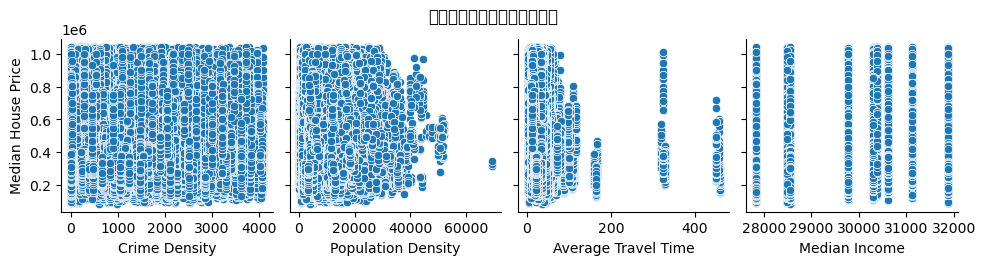

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# 检查自变量和因变量的关系（散点图）
sns.pairplot(
    data=filtered_data,
    x_vars=["Crime Density", "Population Density", "Average Travel Time", "Median Income"],
    y_vars="Median House Price",
    diag_kind="kde"
)
plt.suptitle("自变量与因变量的关系散点图", y=1.02)
plt.show()


/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 27531 (\N{CJK UNIFIED IDEOGRAPH-6B8B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24067 (\N{CJK UNIFIED IDEOGRAPH-5E03}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 30452 (\N{CJK UNIFIED IDEOGRAPH-76F4}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/

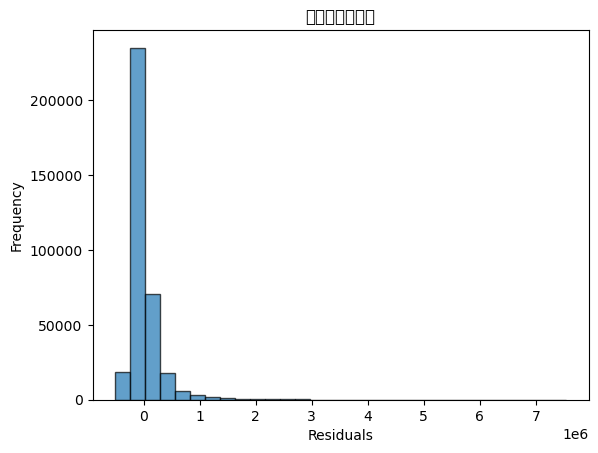

/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26816 (\N{CJK UNIFIED IDEOGRAPH-68C0}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26597 (\N{CJK UNIFIED IDEOGRAPH-67E5}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 27491 (\N{CJK UNIFIED IDEOGRAPH-6B63}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24577 (\N{CJK UNIFIED IDEOGRAPH-6001}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24615 (\N{CJK UNIFIED IDEOGRAPH-6027}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


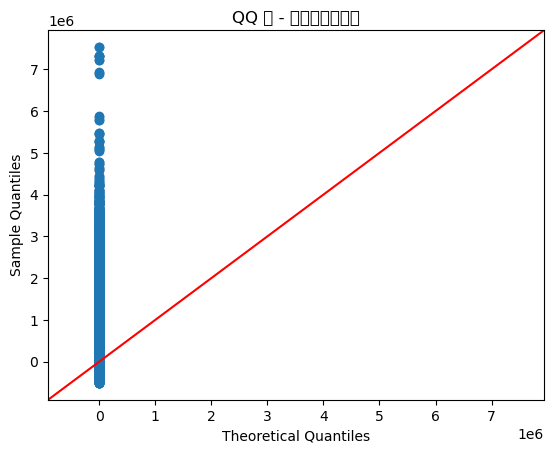

Shapiro-Wilk 检验: p-value = 2.672652213123478e-180
Kolmogorov-Smirnov 检验: p-value = 0.0


/opt/conda/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 356070.
  res = hypotest_fun_out(*samples, **kwds)


In [11]:
import statsmodels.api as sm
from scipy.stats import shapiro, kstest

# 获取残差
residuals = model1.resid  # 使用模型 1 的残差

# 绘制残差直方图
plt.hist(residuals, bins=30, edgecolor="k", alpha=0.7)
plt.title("残差分布直方图")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

# 绘制 QQ 图
sm.qqplot(residuals, line="45")
plt.title("QQ 图 - 检查残差正态性")
plt.show()

# Shapiro-Wilk 检验
shapiro_test = shapiro(residuals)
print(f"Shapiro-Wilk 检验: p-value = {shapiro_test.pvalue}")

# Kolmogorov-Smirnov 检验
kstest_result = kstest(residuals, 'norm')
print(f"Kolmogorov-Smirnov 检验: p-value = {kstest_result.pvalue}")


/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


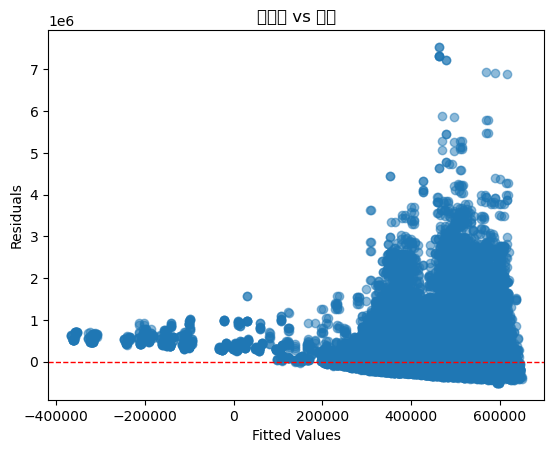

Breusch-Pagan 检验: p-value = 1.1549478170341554e-254


In [12]:
from statsmodels.stats.diagnostic import het_breuschpagan

# 获取预测值
fitted_values = model1.fittedvalues

# 绘制残差 vs 预测值图
plt.scatter(fitted_values, residuals, alpha=0.5)
plt.axhline(0, color="red", linestyle="--", linewidth=1)
plt.title("预测值 vs 残差")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.show()

# Breusch-Pagan 检验
bp_test = het_breuschpagan(residuals, model1.model.exog)
print(f"Breusch-Pagan 检验: p-value = {bp_test[1]}")


In [17]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 计算 VIF
X = filtered_data[["Crime Density", "Population Density", "Average Travel Time","Median Income"]]  # 自变量
X = sm.add_constant(X)  # 添加截距项

vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)


              Variable         VIF
0                const  561.990928
1        Crime Density    1.491727
2   Population Density    1.567302
3  Average Travel Time    1.116346
4        Median Income    1.001272


In [18]:
import numpy as np
import statsmodels.api as sm

# 变量变换（对犯罪密度和人口密度进行对数变换）
filtered_data["Log Crime Density"] = np.log1p(filtered_data["Crime Density"])
filtered_data["Log Population Density"] = np.log1p(filtered_data["Population Density"])

# 定义新的自变量和因变量
X_optimized = filtered_data[["Log Crime Density", "Log Population Density", "Average Travel Time", "Median Income"]]
X_optimized = sm.add_constant(X_optimized)
y_optimized = filtered_data["Median House Price"]

# 拟合线性回归模型
optimized_model = sm.OLS(y_optimized, X_optimized).fit()
print(optimized_model.summary())


                            OLS Regression Results                            
Dep. Variable:     Median House Price   R-squared:                       0.138
Model:                            OLS   Adj. R-squared:                  0.138
Method:                 Least Squares   F-statistic:                 1.322e+04
Date:                Mon, 13 Jan 2025   Prob (F-statistic):               0.00
Time:                        22:57:25   Log-Likelihood:            -4.4493e+06
No. Observations:              331157   AIC:                         8.899e+06
Df Residuals:                  331152   BIC:                         8.899e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                  -1.09

In [23]:
# 对房价和人口密度进行对数变换
filtered_data["Log Median House Price"] = np.log1p(filtered_data["Median House Price"])
filtered_data["Log Population Density"] = np.log1p(filtered_data["Population Density"])


In [24]:
# 定义新的自变量和因变量
X2_optimized = filtered_data[["Log Median House Price", "Log Population Density", "Average Travel Time", "Median Income"]]
X2_optimized = sm.add_constant(X2_optimized)
y2_optimized = filtered_data["Crime Density"]

# 拟合优化后的线性回归模型
optimized_model2 = sm.OLS(y2_optimized, X2_optimized).fit()
print("\n优化后的模型 2: 房价对犯罪率的影响")
print(optimized_model2.summary())



优化后的模型 2: 房价对犯罪率的影响
                            OLS Regression Results                            
Dep. Variable:          Crime Density   R-squared:                       0.307
Model:                            OLS   Adj. R-squared:                  0.307
Method:                 Least Squares   F-statistic:                 3.665e+04
Date:                Mon, 13 Jan 2025   Prob (F-statistic):               0.00
Time:                        23:02:06   Log-Likelihood:            -2.6698e+06
No. Observations:              331157   AIC:                         5.340e+06
Df Residuals:                  331152   BIC:                         5.340e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const  

/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20248 (\N{CJK UNIFIED IDEOGRAPH-4F18}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21270 (\N{CJK UNIFIED IDEOGRAPH-5316}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21518 (\N{CJK UNIFIED IDEOGRAPH-540E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/

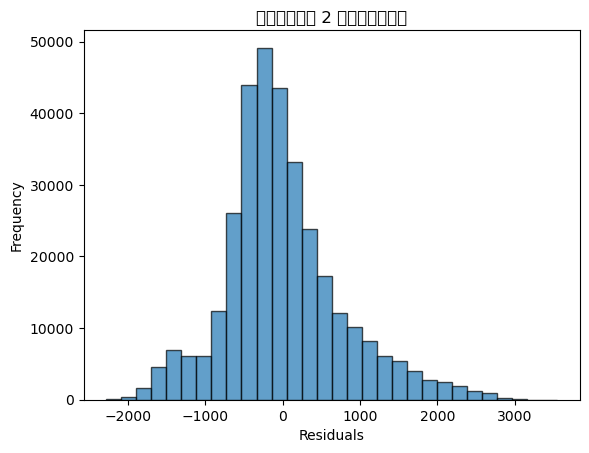

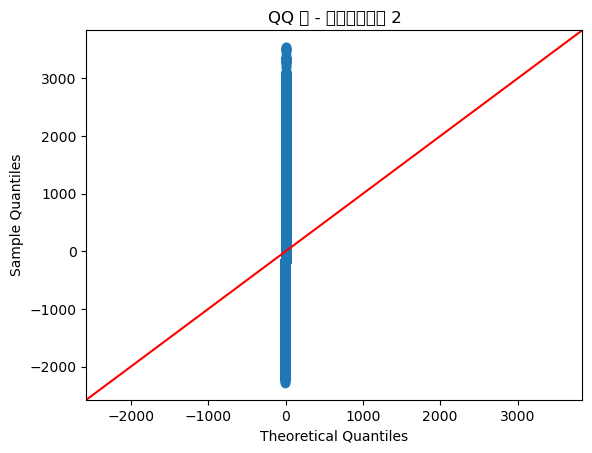

优化后的模型 2 Shapiro-Wilk 检验: p-value = 2.8943594649585224e-110


/opt/conda/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 331157.
  res = hypotest_fun_out(*samples, **kwds)


In [25]:
# 获取优化模型残差
residuals2 = optimized_model2.resid

# 残差直方图
plt.hist(residuals2, bins=30, edgecolor="k", alpha=0.7)
plt.title("优化后的模型 2 残差分布直方图")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

# QQ 图
sm.qqplot(residuals2, line="45")
plt.title("QQ 图 - 优化后的模型 2")
plt.show()

# Shapiro-Wilk 检验
shapiro_test2 = shapiro(residuals2)
print(f"优化后的模型 2 Shapiro-Wilk 检验: p-value = {shapiro_test2.pvalue}")


In [26]:
from statsmodels.stats.diagnostic import het_breuschpagan

# Breusch-Pagan 检验
bp_test2 = het_breuschpagan(residuals2, optimized_model2.model.exog)
print(f"优化后的模型 2 Breusch-Pagan 检验: p-value = {bp_test2[1]}")


优化后的模型 2 Breusch-Pagan 检验: p-value = 0.0


In [27]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 计算 VIF
vif_data2 = pd.DataFrame()
vif_data2["Variable"] = X2_optimized.columns
vif_data2["VIF"] = [variance_inflation_factor(X2_optimized.values, i) for i in range(X2_optimized.shape[1])]

print(vif_data2)


                 Variable          VIF
0                   const  1254.856138
1  Log Median House Price     1.217229
2  Log Population Density     1.162718
3     Average Travel Time     1.169547
4           Median Income     1.210347


In [28]:
import numpy as np
import statsmodels.api as sm
from scipy.stats import mstats

# Winsorize 极端值处理
filtered_data["Crime Density"] = mstats.winsorize(filtered_data["Crime Density"], limits=[0.01, 0.01])

# 对房价和犯罪密度进行对数变换
filtered_data["Log Median House Price"] = np.log1p(filtered_data["Median House Price"])
filtered_data["Log Crime Density"] = np.log1p(filtered_data["Crime Density"])

# 定义新的自变量和因变量
X2_optimized = filtered_data[["Log Median House Price", "Log Population Density", "Average Travel Time", "Median Income"]]
X2_optimized = sm.add_constant(X2_optimized)
y2_optimized = filtered_data["Log Crime Density"]

# 拟合优化后的线性回归模型
optimized_model2 = sm.OLS(y2_optimized, X2_optimized).fit()
print("\n优化后的模型 2: 房价对犯罪率的影响")
print(optimized_model2.summary())



优化后的模型 2: 房价对犯罪率的影响
                            OLS Regression Results                            
Dep. Variable:      Log Crime Density   R-squared:                       0.155
Model:                            OLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                 1.523e+04
Date:                Mon, 13 Jan 2025   Prob (F-statistic):               0.00
Time:                        23:03:39   Log-Likelihood:            -6.1656e+05
No. Observations:              331157   AIC:                         1.233e+06
Df Residuals:                  331152   BIC:                         1.233e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const  